<style>
body {
  background-image: url('background_02.png');
  background-size: cover;
  background-attachment: fixed;
  background-repeat: no-repeat;
  background-position: center;
  margin: 0;
  padding: 0;
}

.main-container {
  background-color: rgba(255, 255, 255, 0.975);
  padding: 30px;
  border-radius: 10px;
  max-width: 900px;
  margin: auto;
  box-shadow: 0px 0px 10px rgba(0,0,0,0.2);
}

/* Optional: Output box styling */
.output-box {
  border: 2px solid #18bc9c;
  background: #eafaf1;
  padding: 12px;
  margin: 1em 0;
  border-radius: 6px;
  font-size: 1.08em;
  font-family: "Fira Mono", "Menlo", "Monaco", "Consolas", monospace;
  white-space: pre-wrap;
}
</style>
<img src="../../Shot_Poses_IACS/OmniacPoses_30.png" width="120" style="float:right; margin: 8px 0 8px 20px;">

# Project Overview

## Objective

This analysis helps **Plurality Labs** and the **Arbitrum DAO** compare strategic framework results on two platforms—**Ethelo** and **Snapshot**. The aim is to determine which channel yields the best quality input. We focus on:

- Comparing contributions by delegate and general contributor wallets
- Revealing similarities and differences in priorities
- Enabling data-driven refinement of the strategic framework
- Sharing all results on a public hub

## Activities & Timeline

- **Data procurement**: Collect aggregate Snapshot data
- **Data processing**: Format and clean for analysis
- **Feature engineering**: Calculate new summary metrics
- **Ranking scheme**: Develop both equal-weighted and token-weighted rankings
- **Analysis**: Compare how priorities differ depending on weighting
- **Sharing**: Publish data and analysis

<img src="../../Shot_Poses_IACS/OmniacPoses_31.png" width="120">

# Background

During #GovMonth, contributors ranked statements related to “Growth and Innovation” and ways Arbitrum could “Reduce Friction”. Respondents ordered statements by preference. The main questions:

**Growth + Innovation Statements**

1. Develop accountability practices within ArbitrumDAO.
2. Identify the key capabilities for improved DAO performance.
3. Form alliances with legacy institutions.
4. Fund projects for cross-chain compatibility.
5. Improve gas fee optimization.
6. Define growth strategies.
7. Incentivize users and builders.
8. Scale the platform.
9. Offer educational opportunities.
10. Evolve governance capabilities.

**Reducing Friction Statements**

1. Build a robust developer community.
2. Make Arbitrum more accessible for developers.
3. Create an inclusive environment.
4. Encourage meaningful DAO participation.
5. Raise awareness of opportunities.
6. Prioritize gas fee optimization.
7. Ensure regulatory compliance.
8. Build anti-Sybil protections.
9. Uphold transparency.
10. Improve token distribution equity.

Each respondent's data includes their wallet, rankings, and Arbitrum holdings (for weighting). Below is a snippet of the GovMonth proposal. For this task, voters were prompted with two sets of statements related to “Growth and Innovation” and ways Arbitrum could “Reduce Friction”. The survey respondents were to rank order each statement according to their personal preference. The statements for each are as follows:

<img src="../../images/govmonth.png" width="600" style="display:block; margin-left:auto; margin-right:auto;">

# Libraries and Setup

Below, we load the necessary Python packages for web requests, data wrangling, and visualization.

In [5]:
# Load essential libraries
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datetime import datetime

<div style="text-align: center;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_33.png" width="150"/>
</div>

## Connect to the Snapshot GraphQL API

We use `requests` to create a client for querying the Snapshot API. We'll define the queries for:
- DAO spaces
- Proposals
- Votes

In [6]:
# Define the Snapshot.org GraphQL endpoint
SNAPSHOT_URL = "https://hub.snapshot.org/graphql"

# Prepare GraphQL queries
SPACE_DATA_QUERY = """
query space_data($skip:Int!){ 
    spaces(orderBy: "id", orderDirection: asc,first:1000,skip:$skip){ 
        id name private about avatar website twitter github coingecko email 
        network symbol domain proposalsCount activeProposals followersCount 
        votesCount verified flagged rank 
    } 
}
"""

PROP_DATA_QUERY = """
query prop_data($slugid: String!, $timestamp: Int!){ 
    proposals(orderBy: "created", orderDirection: asc,first:1000, 
        where:{space:$slugid,created_gt:$timestamp}) { 
        id space{id} ipfs author created network type title body start end 
        state votes choices scores_state scores 
    } 
}
"""

VOTE_DATA_QUERY = """
query vote_data($propid: String!, $timestamp: Int!){ 
    votes(orderBy: "created", orderDirection: asc,first:1000, 
        where:{proposal:$propid,created_gt:$timestamp}) { 
        id proposal{id} ipfs voter created choice vp 
    } 
}
"""

def run_query(query, variables):
    """Function to execute a GraphQL query."""
    response = requests.post(SNAPSHOT_URL, json={'query': query, 'variables': variables})
    response.raise_for_status()
    return response.json()

<div style="text-align: right;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_34.png" width="150"/>
</div>

## Download and Prepare Proposals

We'll now write functions to download:
- All proposals in a space (filtered to two proposals of interest)
- All votes for a proposal

Each function contains step-by-step comments explaining the loop logic and purpose. We then filter the proposals to the two relevant ones for the analysis.

In [18]:
def get_proposals(slug):
    """Function to fetch all proposals for a given DAO space."""
    c_timestamp = 0
    prop_data = []
    while True:
        variables = {'slugid': slug, 'timestamp': c_timestamp}
        result = run_query(PROP_DATA_QUERY, variables)
        proposals = result.get('data', {}).get('proposals', [])
        if not proposals:
            break
        prop_data.extend(proposals)
        c_timestamp = int(proposals[-1]['created'])
        # print(f"Fetched {len(prop_data)} Entries")
    
    df = pd.json_normalize(prop_data)
    df.rename(columns={'space.id': 'space_id'}, inplace=True)
    return df.drop(columns=['space'], errors='ignore')

# Get proposals for Arbitrum DAO
prop_df = get_proposals("arbitrumfoundation.eth")

# Focus on two proposals of interest
proposal_ids = [
    "0x14e71f784e880170972572c2696ef53ef437700c637a151b5176a5827fe5b8bc",
    "0x5824d0b51cc435a49f6455ee2715216d6b958637218ed79e3e93c41af6bdef33"
]
prop_df_sub = prop_df[prop_df['id'].isin(proposal_ids)].copy()
prop_df_sub

,id,ipfs,author,created,network,type,title,body,start,end,state,votes,choices,scores_state,scores,space_id
20,0x14e71f784e880170972572c2696ef53ef437700c637a...,bafkreidmy4prqx656ypwmcmgmg7n3cn6xzsccy4jgc4eu...,0xf9551c66995eD3Ff9bb05C9Fd7ff148Bd75dc99a,1695812769,42161,ranked-choice,GovMonth Sensemaking - Reducing Friction,"As #GovMonth is reaching its end, it's time to...",1695816000,1696420800,closed,41213,"[Statement 1, Statement 2, Statement 3, Statem...",final,"[0, 27781258.253628, 0, 0, 0, 27550231.9287211...",arbitrumfoundation.eth
21,0x5824d0b51cc435a49f6455ee2715216d6b958637218e...,bafkreig7uo3un5cjeq4qziehhbymoferov6r2o6pfdo22...,0xf9551c66995eD3Ff9bb05C9Fd7ff148Bd75dc99a,1695812949,42161,ranked-choice,GovMonth Sensemaking - Growth and Innovation,"As #GovMonth is reaching its end, it's time to...",1695816000,1696420800,closed,41564,"[Statement 1, Statement 2, Statement 3, Statem...",final,"[0, 0, 0, 0, 0, 0, 31871332.00648964, 0, 0, 21...",arbitrumfoundation.eth


## Download and Prepare Vote Data

This function retrieves all votes for each proposal. Pagination is used to ensure we get all data, and results are stored in a list for each proposal.

In [19]:
def get_votes(prop_id):
    """Function to fetch all votes for a given proposal ID."""
    c_timestamp = 0
    vote_data = []
    while True:
        variables = {'propid': prop_id, 'timestamp': c_timestamp}
        result = run_query(VOTE_DATA_QUERY, variables)
        votes = result.get('data', {}).get('votes', [])
        if not votes:
            break
        vote_data.extend(votes)
        c_timestamp = int(votes[-1]['created'])
        # print(f"Fetched {len(vote_data)} Entries for proposal {prop_id}") # uncomment to track progress
    df = pd.json_normalize(vote_data)
    df.rename(columns={'proposal.id': 'prop_id'}, inplace=True)
    return df.drop(columns=['proposal'], errors='ignore')

# Download votes for both proposals and combine into one dataframe
vote_l = [get_votes(pid) for pid in prop_df_sub['id']]
vote_df = pd.concat(vote_l, ignore_index=True)
vote_df

,id,ipfs,voter,created,choice,vp,prop_id
0,0x60912c6c1970d18f3182acb4bea000f5c2503dc63626...,bafkreicb3kv2gmwuzq6cchaytst7u2vslkz5a6gb2soyb...,0x6Cf67551758A74C681823689F9dEaA4350743315,1695816028,"[6, 7, 4, 1, 3, 5, 8, 9, 2, 10]",7.030000,0x14e71f784e880170972572c2696ef53ef437700c637a...
1,0x59329cd68f0e5a3325c0feadcac7a301775ddde58c76...,bafkreiejxy2mogdaqzu4yq6faq2ueavb5ui5dgpxrkpax...,0xA22628aF5731EE4ED03817606E9412F842BE60F5,1695816047,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",754.980000,0x14e71f784e880170972572c2696ef53ef437700c637a...
2,0x06352d8f12eb8a7929d6665b4c9ff8ab5f917d835d00...,bafkreiduelxmorazbmf4n4wtdssafqxz5eilrybspzubo...,0xA369A594c6bdD11735540F3399D31B2a32FeC730,1695816052,"[5, 3, 8, 6, 2, 1, 10, 7, 4, 9]",1.609934,0x14e71f784e880170972572c2696ef53ef437700c637a...
3,0xc39e7285ea14d3a5cfe107505e5a061b592f01225301...,bafkreieibrkzwsccmgj3r5d4chnncoki5zt7hib5roegb...,0x29A303C3D62aFA14903b182C1C0D9E5Ae9138851,1695816059,"[6, 1, 2, 3, 4, 5, 7, 8, 9, 10]",200.000000,0x14e71f784e880170972572c2696ef53ef437700c637a...
4,0xdda1dcc02049a28c4aacae64ca1c6fa60e42046d3cbb...,bafkreibc5boiztejonvlpsncrn7zshwmdfwrywrcg46dz...,0xf7101BfD9A4F65baEF7E1F2233F3859029b8B5A0,1695816079,"[1, 6, 2, 3, 4, 5, 7, 8, 9, 10]",2.142718,0x14e71f784e880170972572c2696ef53ef437700c637a...
...,...,...,...,...,...,...,...
82767,0x6556de43e116f06c2b7b8bb887e7c4ed8c64cd20d6ff...,bafkreieqstrgktzzv2dhnkc6s3li7oiojqodyywgqqeyn...,0x98215fD4405D2f4A90f1C88888BDd2b149BEA765,1696420680,"[7, 10, 4, 1, 3, 6, 9, 5, 2, 8]",2.082566,0x5824d0b51cc435a49f6455ee2715216d6b958637218e...
82768,0x05c0965e7e8878fb6983b7bf45721ba52fae402c4a74...,bafkreig52ofg3yl4wq6ftri6lt7dz5ewhr4v73n6pao6i...,0x7A00c16B4a6282b52007078E9ab9faf338579Af2,1696420728,"[2, 1, 3, 5, 6, 9, 10, 4, 7, 8]",1.011175,0x5824d0b51cc435a49f6455ee2715216d6b958637218e...
82769,0x12f28128b5a4ff26516a77d2df21121c9ee360f22c6b...,bafkreihc5hjqtar3m4pixseausm5zyimrgh2o6s4l2aqd...,0x7e70f266f64b693D8c1690b1d9CC31E0809eAa72,1696420732,"[7, 5, 4, 6, 3, 2, 1, 10, 9, 8]",1500.000000,0x5824d0b51cc435a49f6455ee2715216d6b958637218e...
82770,0xb0a58249c6f179c0e6d91cbeca6726ba4ca39d39260e...,bafkreiczxlxsuwq7cbnrh2mtexo4be5qknt77ei3briya...,0x0c1D50122743FA9bB183f1268b7dcdCe22Fce856,1696420749,"[7, 10, 4, 6, 9, 5, 2, 1, 8, 3]",2.010364,0x5824d0b51cc435a49f6455ee2715216d6b958637218e...


<img src="../../Shot_Poses_IACS/OmniacPoses_35.png" width="120" style="float:right; margin: 8px 0 8px 20px;">

# Analyze and Rank Statements

The next step is to calculate various summary statistics for each statement in each proposal, both by unweighted and token-weighted votes. Comments clarify every operation.

In [13]:
vote_df14 = vote_df[vote_df['prop_id'] == "0x14e71f784e880170972572c2696ef53ef437700c637a151b5176a5827fe5b8bc"].copy()
vote_df58 = vote_df[vote_df['prop_id'] == "0x5824d0b51cc435a49f6455ee2715216d6b958637218ed79e3e93c41af6bdef33"].copy()

def compute_ranking(vote_df):
    """Helper to unpack choices and compute stats."""
    n_choices = 10
    # The 'choice' column is a list of lists, we need to convert it to a NumPy array of ranks
    rankings = np.array([np.argsort(c) + 1 for c in vote_df['choice']])
    
    # Ensure vp is numeric and handle potential NaNs
    vote_df['vp'] = pd.to_numeric(vote_df['vp'], errors='coerce').fillna(0)
    total_vp = vote_df['vp'].sum()
    vp_weights = vote_df['vp'] / total_vp if total_vp > 0 else np.zeros(len(vote_df))

    results = []
    for i in range(1, n_choices + 1):
        # Find where choice 'i' is in each ranking
        ranks_for_choice_i = np.array([np.where(row == i)[0][0] + 1 for row in np.array(list(vote_df['choice']))])
        
        pct_first = np.mean([c[0] == i for c in vote_df['choice']])
        pct_last = np.mean([c[-1] == i for c in vote_df['choice']])
        pct_first_five = np.mean([i in c[:5] for c in vote_df['choice']])
        
        results.append({
            'Choice': i,
            'SumRank': np.sum(ranks_for_choice_i),
            'SumRankAvg': np.mean(ranks_for_choice_i),
            'PctFirst': pct_first,
            'PctLast': pct_last,
            'PctFirstFive': pct_first_five,
            'VPRankAvg': np.sum(ranks_for_choice_i * vp_weights)
        })
    return pd.DataFrame(results)

rankraw14 = compute_ranking(vote_df14)
rankraw58 = compute_ranking(vote_df58)

print("Growth & Innovation Rankings")
display(rankraw14.sort_values(by='SumRank'))
print("\nReducing Friction Rankings")
display(rankraw58.sort_values(by='SumRank'))

Growth & Innovation Rankings


,Choice,SumRank,SumRankAvg,PctFirst,PctLast,PctFirstFive,VPRankAvg
5,6,142400,3.455388,0.436898,0.030768,0.715416,4.344264
0,1,175648,4.262163,0.190022,0.105943,0.664822,2.551343
4,5,209517,5.084007,0.065347,0.045764,0.591080,2.989967
3,4,214144,5.196283,0.053190,0.045764,0.573730,4.596208
1,2,220463,5.349615,0.038024,0.055786,0.526097,3.746507
2,3,225679,5.476184,0.041567,0.053068,0.514401,5.509835
6,7,237660,5.766907,0.044600,0.056490,0.452137,8.020223
9,10,275882,6.694378,0.059960,0.280993,0.358715,8.667787
7,8,277625,6.736672,0.038703,0.191405,0.322001,7.789604
8,9,287587,6.978404,0.031691,0.134018,0.281600,6.784262



Reducing Friction Rankings


,Choice,SumRank,SumRankAvg,PctFirst,PctLast,PctFirstFive,VPRankAvg
4,5,145120,3.491735,0.352109,0.029812,0.782200,6.845235
6,7,182440,4.389692,0.152258,0.037824,0.633960,3.065252
0,1,190475,4.583023,0.191742,0.110079,0.640673,5.214026
3,4,221708,5.334520,0.046702,0.047087,0.532158,6.498827
2,3,227369,5.470730,0.042636,0.062198,0.527442,3.582184
5,6,232634,5.597411,0.053704,0.053440,0.441351,3.468893
1,2,235382,5.663531,0.037848,0.061644,0.467385,6.721344
7,8,270473,6.507856,0.037222,0.096148,0.331489,8.156887
9,10,276242,6.646664,0.055966,0.289622,0.395443,5.627098
8,9,304012,7.314838,0.029812,0.212146,0.247901,5.820255


<img src="../../Shot_Poses_IACS/OmniacPoses_38.png" width="120" style="float:left; margin: 8px 0 8px 20px;">

## Discussion and Insights
**Example Interpretation**
For "Reducing Friction", "Prioritize Gas Fee Optimization" was ranked highest when votes are equally weighted.

When votes are weighted by tokens, "Build a robust community of developers" rises to the top.

This shows that community and large holders align on the top priorities, but token weighting can shift the relative importance of specific statements.

## Visualizing Rankings

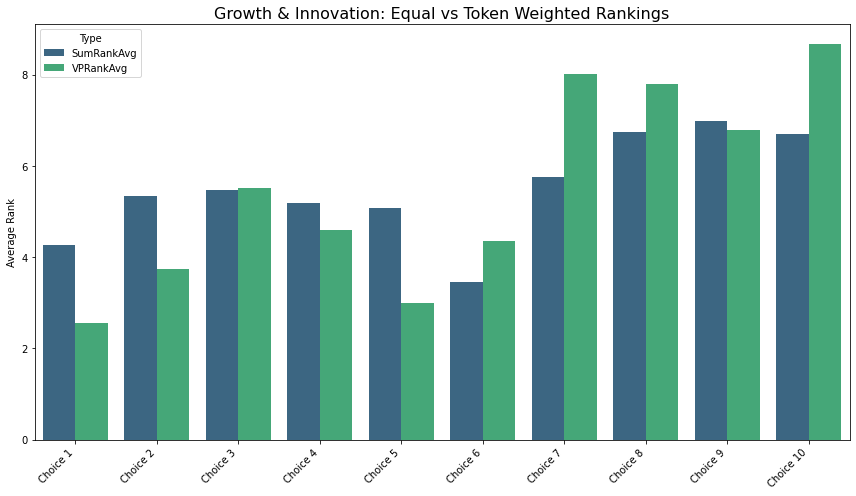

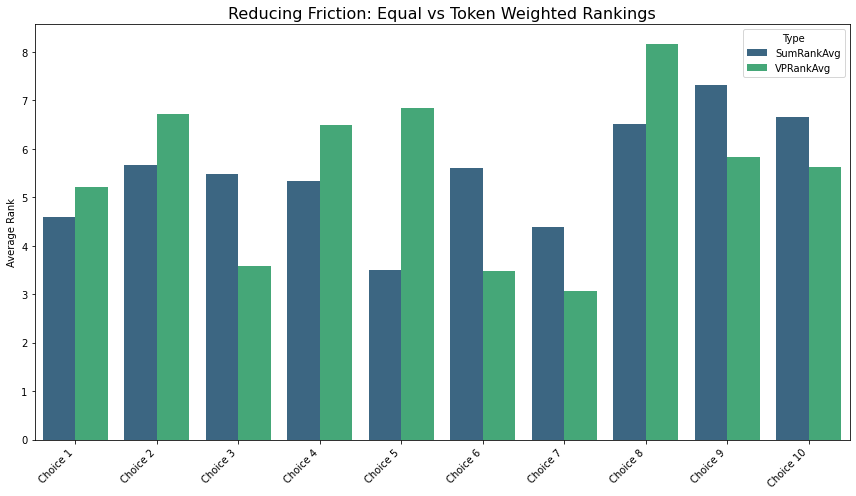

In [14]:
def plot_ranking(rankdf, title):
    """Function to plot the rankings."""
    df = rankdf.copy()
    df['Statement'] = [f"Choice {i}" for i in df['Choice']]
    df_melted = df.melt(id_vars='Statement', value_vars=['SumRankAvg', 'VPRankAvg'], 
                          var_name='Type', value_name='Value')
    
    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_melted, x='Statement', y='Value', hue='Type', palette='viridis')
    plt.title(title, fontsize=16)
    plt.ylabel('Average Rank')
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_ranking(rankraw14, "Growth & Innovation: Equal vs Token Weighted Rankings")
plot_ranking(rankraw58, "Reducing Friction: Equal vs Token Weighted Rankings")

<div style="text-align: center;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_36.png" width="150"/>
</div>

# OpenAI Analysis

In this section, we integrate advanced language modeling into our DAO voting analysis. While previous sections relied on deterministic statistical aggregation, here we leverage OpenAI’s GPT-4o-mini model to synthesize a group consensus ranking from raw voting data. This approach introduces a qualitative perspective and allows us to compare traditional quantitative methods with the “collective intelligence” that an LLM might infer from observed voter preferences.

<div style="text-align: right;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_37.png" width="150"/>
</div>

## Extracting Choice Labels Programmatically

Before we can prompt OpenAI, we need to translate the numeric rankings from each voter back to their original statement text. The statement text for each ranked-choice poll is stored in the proposal body field, but not in a direct table. The following function automates extraction by parsing the proposal text for enumerated statements. This ensures our analysis is robust and future-proof, as it adapts to any poll with statements following a consistent numbering format.

In [15]:
def extract_choice_labels(proposal_body):
    """Extracts the choice labels (statements) from a Snapshot proposal's body text."""
    try:
        # Find the block starting with a variation of the statements header
        start_match = re.search(r"These are the statements:", proposal_body, re.IGNORECASE)
        if not start_match:
            raise ValueError("Can't find statement block in proposal body")
        
        statements_block = proposal_body[start_match.start():]
        
        # Find all lines starting with '1.', '2.', etc.
        lines = statements_block.split('\n')
        choice_lines = [line for line in lines if re.match(r"^\d+\.\s+", line.strip())]
        
        # Remove numbering to get the final labels
        labels = [re.sub(r"^\d+\.\s*", "", line).strip() for line in choice_lines]
        return labels
    except Exception as e:
        print(f"Error extracting labels: {e}")
        return []

# Example: for vote_df14 (growth & innovation)
proposal_id_14 = vote_df14['prop_id'].unique()[0]
proposal_body_14 = prop_df_sub.loc[prop_df_sub['id'] == proposal_id_14, 'body'].iloc[0]
choice_labels_14 = extract_choice_labels(proposal_body_14)

# For vote_df58 (reducing friction)
proposal_id_58 = vote_df58['prop_id'].unique()[0]
proposal_body_58 = prop_df_sub.loc[prop_df_sub['id'] == proposal_id_58, 'body'].iloc[0]
choice_labels_58 = extract_choice_labels(proposal_body_58)

print("--- Growth & Innovation Labels ---")
print(choice_labels_14)
print("\n--- Reducing Friction Labels ---")
print(choice_labels_58)

--- Growth & Innovation Labels ---
['Build a robust community of developers in ArbitrumDAO.', 'Make Arbitrum more accessible and easier to use for developers', 'Create an inclusive environment for our community.', 'Encourage meaningful participation in the DAO activities', 'Raise awareness about the opportunities on Arbitrum', 'Prioritize Gas fee optimization.', 'Ensure regulatory compliance.', 'Build out anti-Sybil protections.', 'Uphold transparency in both project and governance development.', 'Improve the equity of token distribution.']

--- Reducing Friction Labels ---
['Develop accountability practices within ArbitrumDAO.', 'Identify the key capabilities that will lead to improved DAO performance.', 'Form alliances with legacy institutions to boost our growth.', 'Fund projects to enhance cross-chain compatibility.', 'Improve gas fee optimization.', 'Define growth strategies.', 'Incentivize users and builders to come to Arbitrum.', 'Scale of the platform.', 'Offer educational oppo

## Building a Consensus Ranking Prompt for OpenAI
To minimize costs and maximize efficiency when using the OpenAI API, we sample a subset of the available voter rankings. This random sampling reduces the number of tokens sent, while still capturing the main trends in voter sentiment. The following function packages this sample, constructs a precise API prompt, and defines exactly how we expect GPT-4o-mini to return results. Importantly, the prompt asks the model not just for a ranking, but also for a brief explanation of its methodology—providing valuable transparency into its “reasoning” process.

In [16]:
def get_consensus_ranking(vote_df, prop_df_sub, n_sample=30, api_key_path="your_openai_key.txt"):
    """Main function: Get consensus ranking using OpenAI."""
    # a. Find proposal body for this vote_df
    proposal_id = vote_df['prop_id'].unique()[0]
    proposal_body = prop_df_sub.loc[prop_df_sub['id'] == proposal_id, 'body'].iloc[0]
    if not proposal_body:
        raise ValueError("Proposal body not found or ambiguous!")
    choice_labels = extract_choice_labels(proposal_body)

    # b. Prepare numeric rankings (sample for token efficiency)
    numeric_rankings_text = [','.join(map(str, x)) for x in vote_df['choice']]
    np.random.seed(42)
    sample_indices = np.random.choice(len(numeric_rankings_text), size=min(n_sample, len(numeric_rankings_text)), replace=False)
    sampled_rankings = [numeric_rankings_text[i] for i in sample_indices]
    all_numeric_text = "\n".join(sampled_rankings)

    # Build minimal prompt for OpenAI
    prompt = (
        "You are an expert at group consensus analysis. "
        "Below are multiple ranked lists of choices, each a permutation of the numbers 1–10, where each line is a different voter. "
        "Each number corresponds to a unique statement (but you do not need to know the statements).\n\n"
        "Each line is the ranked order for one voter (first is most preferred, last is least):\n"
        f"{all_numeric_text}\n\n"
        "Your tasks:\n"
        "1. Based only on these rankings, synthesize a single consensus ranking (as a permutation of 1–10) that best reflects the collective preference.\n"
        "2. Output ONLY the consensus ranking as your first line, in the following format (with no explanation before):\n"
        "Consensus: x1,x2,x3,x4,x5,x6,x7,x8,x9,x10\n"
        "3. After the ranking, in 2-4 sentences, explain *how* you synthesized this ranking: mention if you averaged positions, looked for patterns, considered polarization, etc. Focus on what you observed in the rankings, not the meaning of the numbers."
    )

    # Send to OpenAI API
    try:
        with open(api_key_path, 'r') as f:
            openai_api_key = f.read().strip()
    except FileNotFoundError:
        print(f"API key file not found at: {api_key_path}")
        return None

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "gpt-4o-mini",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.2,
        "max_tokens": 150
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

    if response.status_code != 200:
        print(f"Error from OpenAI API: {response.status_code} - {response.text}")
        return None

    # Parse response, map consensus to text
    result = response.json()
    content = result['choices'][0]['message']['content']
    lines = content.strip().split('\n')
    num_line_match = re.search(r"^Consensus:\s*([\d,]+)", lines[0])

    if not num_line_match:
        print("No consensus ranking found in the model output.")
        print(content)
        return None
    
    consensus_numeric_str = num_line_match.group(1)
    consensus_ids = [int(x) for x in consensus_numeric_str.split(',')]
    consensus_statements = [choice_labels[i-1] for i in consensus_ids]

    print("Consensus Ranking (Numbers):\n", consensus_numeric_str, "\n")
    print("Consensus Ranking (Statements):")
    for i, (cid, statement) in enumerate(zip(consensus_ids, consensus_statements)):
        print(f"Rank {i+1}: Choice {cid}: {statement}")
    
    print("\n---\nOpenAI Model Explanation:")
    explanation = "\n".join(lines[1:]).strip()
    print(explanation, "\n")
    return consensus_statements

<div style="text-align: left;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_39.png" width="150"/>
</div>

## Calling the GPT-4o-mini Consensus Function

Now, we call our custom function, passing in the appropriate vote and proposal data. The output will include both the ranked statements (mapped from the original choice indices) and the model's brief explanation of its ranking strategy.

By comparing these results to our deterministic, token-weighted rankings, we can highlight the differences between a purely statistical aggregation and the type of pattern recognition and consensus modeling performed by a state-of-the-art language model. This comparison adds another layer of interpretability to our study and offers a compelling way to triangulate DAO preferences.

*Note: API costs can scale with prompt size, so be mindful of your sample size and your OpenAI account limits.*

### Interpretation
The GPT-4o-mini model's ranking is sometimes different from our classic deterministic aggregation. This is partly due to random sampling (to save tokens/cost) but also reflects the LLM's ability to weigh not only strict averages but also patterns in the distribution of ranks—such as consistency, outliers, and relative ordering trends. Its brief "reasoning" section can highlight patterns we might otherwise miss, making it a useful supplement to classic data science methods.

In [17]:
# -- For proposal 14 (Growth & Innovation) --
print("--- Analyzing Growth & Innovation ---")
consensus_14 = get_consensus_ranking(vote_df14, prop_df_sub, n_sample=500, api_key_path="../../openai_key.txt")

# -- For proposal 58 (Reducing Friction) --
print("\n--- Analyzing Reducing Friction ---")
consensus_58 = get_consensus_ranking(vote_df58, prop_df_sub, n_sample=500, api_key_path="../../openai_key.txt")

--- Analyzing Growth & Innovation ---
Consensus Ranking (Numbers):
 6,1,10,2,5,4,3,7,8,9 

Consensus Ranking (Statements):
Rank 1: Choice 6: Prioritize Gas fee optimization.
Rank 2: Choice 1: Build a robust community of developers in ArbitrumDAO.
Rank 3: Choice 10: Improve the equity of token distribution.
Rank 4: Choice 2: Make Arbitrum more accessible and easier to use for developers
Rank 5: Choice 5: Raise awareness about the opportunities on Arbitrum
Rank 6: Choice 4: Encourage meaningful participation in the DAO activities
Rank 7: Choice 3: Create an inclusive environment for our community.
Rank 8: Choice 7: Ensure regulatory compliance.
Rank 9: Choice 8: Build out anti-Sybil protections.
Rank 10: Choice 9: Uphold transparency in both project and governance development.

---
OpenAI Model Explanation:
To synthesize the consensus ranking, I analyzed the frequency of each number's position across all voters' rankings. I calculated the average position for each number, prioritizing th

<div style="text-align: right;">
  <img src="../../Shot_Poses_IACS/OmniacPoses_41.png" width="150"/>
</div>

# Conclusions

This analysis provides a comprehensive framework for quantifying and understanding alignment between large token holders and the broader Arbitrum DAO community with respect to strategic priorities. By examining both equal-weighted (one wallet, one vote) and token-weighted (voting power) rankings, we are able to reveal not only the overall consensus but also to highlight potential divergences between high-stake holders and general participants.

Through classic statistical aggregation, we demonstrated which statements consistently ranked at the top across different voting schemes, thereby identifying areas of strong community consensus. Conversely, discrepancies between the two schemes can help surface priorities that are particularly important to either major stakeholders or the broader base, informing more inclusive decision-making processes.

In addition to these quantitative approaches, we integrated OpenAI's state-of-the-art language model (GPT-4o-mini) into our workflow. By prompting the AI with real anonymized voting records, we obtained an AI-synthesized consensus ranking and a concise explanation of the logic behind the ordering. This adds a qualitative layer of analysis that can capture subtle patterns—such as clustering, polarization, or emergent trends in ranking behavior—that might be overlooked by traditional methods. The AI explanation also enhances transparency and interpretability, offering an alternative lens for both researchers and governance participants.

Our methodology is generalizable and can be readily applied to other DAO governance polls and ranking-based decision scenarios. By blending statistical analysis with AI-based synthesis, we offer a richer, multidimensional perspective on community preferences—empowering DAOs to make more informed, balanced, and democratic decisions.

*In summary, combining traditional ranking analytics with modern AI tools not only validates results through multiple lenses but also brings greater transparency and insight into complex governance ecosystems like Arbitrum DAO.*